# Text As Data

## Part 1: Set-up


In [1]:
import pandas as pd
import string
import numpy as np
from os import listdir
from nltk.corpus import stopwords
import nltk
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation as LDA
from nltk.stem import WordNetLemmatizer 
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
import glob
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_validate
import statistics

**1. To begin, you will ﬁrst work through processing the data. Start by loading in the training data and test data. Keep each in their own dataframe/list (i.e. a dataframe/list for all training observation text and a separate one for all test observations). How many training and test observations do you have?**


Answer : There are 528 training observations and 111 Test observations.

In [2]:
#Loading training data as a dataframe
train_file = os.listdir('./train')

#Storing the file name,speaker name and quote in the dataframe
train_df = pd.DataFrame(columns=['FileName','Speaker','Quote'])
for file in train_file :
    file_name = file.split("_")[0]
    file_data = open('./train/'+file,'r',encoding='UTF-8')
    data = file_data.readline()
    speaker = data.split(":")[0]
    quote = data[data.find(":")+1:]
    train_df=train_df.append({'FileName': file_name,'Speaker': speaker,'Quote':quote},ignore_index=True)


print("Number of records in the training dataset is ", len(train_df))

    
    


Number of records in the training dataset is  528


In [3]:
#Loading test data directory
test_file = sorted(os.listdir('./test'))
#Storing the  quote in the list
test_data = pd.DataFrame()
for file in test_file :
    file_data = open('./test/'+file,'r',encoding='UTF-8')
    data = file_data.readline()
    seq = int((file.split('_')[1]).split('.')[0])
    test_data = test_data.append({'FileName':file,'Quote':data,'Seq':seq},ignore_index=True)
    
print("Number of records in the test dataset is ", len(test_data))

 

Number of records in the test dataset is  111


**2. Create a vector of training labels. These labels can be found in one of two ways: in the ﬁle name of each training data observation and at the beginning of the text for each training ﬁle. The test data will not have the labels at the beginning of the text so remove these labels from your training observations. Are there any instances where the name of the ﬁle does not align with the name at the start of the text? If so, how many such observations are there? Exclude these from your training data. What does the distribution of labels look like? Comment on what you see.**

Answer: We can see that there are no instances where the name of the file does not align with the name of the start of the text. On plotting a histogram to examine the distribution of the class labels we can see there is an imbalance between the number of observations for each class.We can see that the class Warren has 80 observations,Sanders and Biden have 60 observations while the classes Gabbard and Steyer have only 16 and 19 observations respectively. This is less or equal to 1/4th of the observations in the majority class (Warren).
    

In [4]:
#Creating a vector of the file names as the training labels
training_label = np.array(train_df.iloc[:,0])

#Checking if there are instances where the file name does not concide with the speaker name in the file
check=[]

#Extracting the surname of the speaker to compare with the file name
train_df['speaker_surname'] = train_df['Speaker'].apply(lambda x:x.split(' ')[1])

#Comparing the rows where file name is same as the beginning of the text
check = np.where(train_df.FileName==train_df.speaker_surname, True, False)

print("The number of instances where the name of the file does not align with the name at the start of the text are ",list(check).count(False))

#Storing only the quotes in the training set that will be used in for our modelling
train_data = train_df.iloc[:,2]

The number of instances where the name of the file does not align with the name at the start of the text are  0


Counter({'Biden': 60,
         'Booker': 50,
         'Buttigieg': 60,
         'Castro': 23,
         'Gabbard': 16,
         'Harris': 40,
         'Klobuchar': 55,
         "O'Rourke": 33,
         'Sanders': 60,
         'Steyer': 19,
         'Warren': 80,
         'Yang': 32})

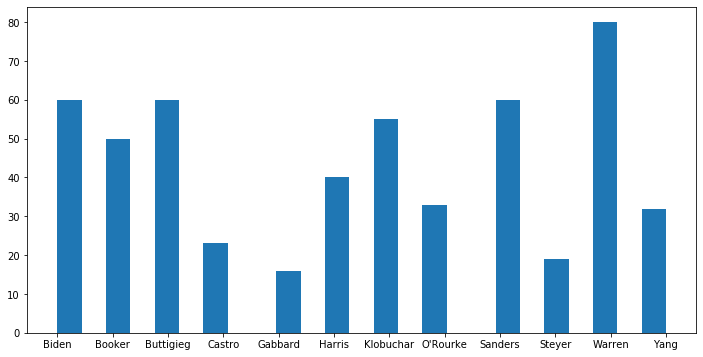

In [5]:
#Plotting a histogram of the training labels
fig = plt.figure(figsize=(12,6))
plt.hist(training_label, bins = 25)
from collections import Counter
Counter(training_label)

**3. Convert the training data to lower case. Remove punctuation from the training data. Also remove stop words from the training data using the NLTK package’s English stop word list. In addition to NLTK’s stopwords, are there words speciﬁc to this dataset that may be worthwhile to treat as stop words? What are these words and why would you exclude them? Remove these additional stop words from the training data as well (note: you can also remove this secondary set of stop words after tokenizing. However, keep in mind that this may cause feature alignment issues with your test dataset when you tokenize it.**

Answer : Other than NLTK's inbuilt stopwords, I removed additional words based on the following criteria:
1. President,Presidential,People,American - Since the data is related to the statements made by the democratic candidates for the presidential elections, I removed words that are commonly used in this domain such as president,presidential,people and american which have high occurences and hence they could be treated as stop words.

In [6]:

#Converting the training data to lowercase
train_data = train_data.str.lower()

#removing punctuation from the training data
train_data = train_data.str.replace(r"[#$%&'()*+,-./:;<=>“?’”@[\]^_`{|}~…]",'')

#removing stop words from the training data
stops = stopwords.words('english')

train_data = train_data.apply(lambda x :' '.join([word for word in x.split() if word not in stops]) )

#removing extra stop words from the test data
extra_words = ['presidential','president','american','people']

train_data = train_data.apply(lambda x :' '.join([word for word in x.split() if word not in extra_words]) )


In [7]:
#Printing first four rows of the cleaned data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
train_data.head(4)

0    refuse postpone longer taking climate change leading world taking climate change look united states america theres never single solitary time weve set mind something weve able walking around heads like woe best equipped nation world take longer time postpone get moving theres enormous enormous opportunities get rid donald trump                                                                                                                                                                                                                                                                                                                                           
1    got done im one whos ever beat nra one ever beat nra nationally im guy brought brady bill focus became law thats number one number two sandy hook number things happened went cause movement look whats happened mothers organization mothers gun violence weve seen whats happened young marching washington making sure things going ch

4. Stem/lemmatize your training data using a stemmer/lemmatizer of your choosing. Show a before and after using a few observations and comment on what you see.


Answer : On lemmatizing the data I can see several words are modified to remove their plural endings such as "latinos" was modified to "latino","scholars" was modified to "scholar", "weapons" to "weapon" etc.

In [8]:
#Printing the first four rows of the dataset before using the lemmatizer
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
print("First five rows of the training data before lemmitizing : ")
print(train_data.head(4))

First five rows of the training data before lemmitizing : 
0    refuse postpone longer taking climate change leading world taking climate change look united states america theres never single solitary time weve set mind something weve able walking around heads like woe best equipped nation world take longer time postpone get moving theres enormous enormous opportunities get rid donald trump                                                                                                                                                                                                                                                                                                                                           
1    got done im one whos ever beat nra one ever beat nra nationally im guy brought brady bill focus became law thats number one number two sandy hook number things happened went cause movement look whats happened mothers organization mothers gun violence weve seen whats hap

In [9]:
#Printing the first four rows of the dataset after using the lemmatizer
print(" ")
#Using WordNetLemmatizer from nltk.stem
lemmatizer = WordNetLemmatizer() 
train_data = train_data.apply(lambda x :' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

print("First five rows of the training data after lemmitizing : ")
print(train_data.head(4))

 
First five rows of the training data after lemmitizing : 
0    refuse postpone longer taking climate change leading world taking climate change look united state america there never single solitary time weve set mind something weve able walking around head like woe best equipped nation world take longer time postpone get moving there enormous enormous opportunity get rid donald trump                                                                                                                                                                                                                                                                                                                                   
1    got done im one who ever beat nra one ever beat nra nationally im guy brought brady bill focus became law thats number one number two sandy hook number thing happened went cause movement look whats happened mother organization mother gun violence weve seen whats happened young march

**5. Tokenize your training data using unigrams (hint: see sklearn’s CountVectorizer). If you set upper and lower limits on word frequency, what are they? How many unique tokens are in your vocabulary?**

Answer : I set a maximum and minimum word document frequency while using CountVectorizer to remove words that occur in less than two documents and words that occur in more than 80% of the document to prevent these commonly used words to skew our predictions when we train our model. After setting the word document frequency limits, I have 2351 unique tokens in my vocabulary.

In [10]:
#Setting the vectorizer to remove terms that occur in more than 80 percent documents and less than 2 documents
vec = CountVectorizer(min_df=2,max_df=0.8)

vec.fit(train_data)
countsDF =pd.DataFrame()
train_counts = vec.transform(train_data)
#Creating an array of the training 
train_counts = train_counts.toarray()
countsDF = pd.DataFrame(train_counts,columns=vec.get_feature_names())
train_features = vec.get_feature_names()
#Print the number of unique tokens in the vocalulary
print("The number of unique tokens that are in the train data vocabulary are ",len(set(vec.vocabulary_)))

#Using tfidf to gain the term frequency only taking unigrams
tfidf = TfidfTransformer()
train_unigram_tfidf = tfidf.fit_transform(train_counts)

The number of unique tokens that are in the train data vocabulary are  2351


**6. Process the test data in a manner identical to the training data. Note that you will need to have the same dimensions for your training and test data. One way in which this can be done is using sklearn’s CountVectorizer is to ﬁt on the training data and transform the test data. Show that the number of features for your training and test data are identical.**



Answer : As we can see below, both our training and test dataset have 2351 features.

In [11]:
#Converting the test data to lowercase
test_data = test_data.apply(lambda x: x.astype(str).str.lower())

#removing punctuation from the test data
test_data =test_data.apply(lambda x : x.astype(str).str.replace(r"[#$%&'()*+,-./:;<=>“?’”@[\]^_`{|}~…]",''))

#removing stop words from the test data
test_data = pd.DataFrame(test_data['Quote'].apply(lambda x :' '.join([word for word in x.split() if word not in stops]) ))


#removing extra stop words from the test data
extra_words = ['presidential','president','american','people']

test_data = pd.DataFrame(test_data['Quote'].apply(lambda x :' '.join([word for word in x.split() if word not in extra_words]) ))



In [12]:
#Using WordNetLemmatizer from nltk.stem
test_data = pd.DataFrame(test_data['Quote'].apply(lambda x :' '.join([lemmatizer.lemmatize(word) for word in x.split()])))

#Setting the vectorizer to remove terms that occur in more than 80% documents and less than 2 documents
vec2 = CountVectorizer(min_df=2,max_df=0.8)

#Fitting the vectorizer on the training data
vec2.fit(train_data)

#Transforming the words in the test dara using  thevectorizer
counts_test = vec2.transform(test_data['Quote']).toarray()

#Print the number of unique tokens in the vocalulary
print("The number of unique tokens that are in the test data vocabulary are ",len(vec2.vocabulary_))



The number of unique tokens that are in the test data vocabulary are  2351


## Part 2: Supervised Learning

7. The primary objective of this problem set is to build classiﬁers to predict who said what. Having the right features are essential for this (and any) prediction task. In addition to the features you were tasked with generating in Part 1, design/build additional features of your choosing. Please note that this process can be iterative in a cycle of designing/adding features and evaluating model performance - this is completely reasonable and you can come back to this question after completing the remainder of Part 2. Describe the features that you ultimately used in your ﬁnal models and articulate your reasoning for including the features that you did. Also describe any feature manipulation/scaling you did and your reasoning for doing so. Ensure your test set has identical features as your training set. Some potential ideas for additional features include bi-/trigrams, topic model weights, TF-IDF weights, sentiments, hand-engineered word co-occurrences (not adding any/all of these is completely ﬁne as well).

Answer : Additional features I have added to my model include TF-IDF weights of each deature to take into account the weights of the features with respect to their occurences in the different documents as well as bigrams to get a better understanding of the context of words.For example, the word country as a unigram may have several interpretations but on adding bigrams, we can see that the word 'country' can have several interpretations when it is placed independently. However when combined with other words the context is easier to understand such as "country woman","country healthcare" and "country immigration".
On adding biagrams as well to our feature set we get the number of featires in our test and training set to be 4749.

Further, since our training labels have a high class imbalance, in order to ensure the models do not overfit by predicting the majority classes accurately but failing to predict the minority classes on unobserved data, I used k fold stratified sampling to split my training dataset into a training and validation set to ensure that the propotion of distribution of all the classes are uniform in the training and validation set (I have set the number of folds to 4, hence 1/4th of the number of values of each class is given to the validation set and 3/4th is given to the training set)  so that the model is able to recognize all the classes while training and is able to predict all the labels while testing the model's performance on the validation set.


In [13]:

#Including bigrams in our model :
tfidf_bigram = TfidfVectorizer(min_df=2,max_df=0.8,ngram_range=(1,2))

train_bigram_tfidf= tfidf_bigram.fit_transform(train_data).toarray()
print("Length of new training features is ",len(tfidf_bigram.vocabulary_))


#Fitting our test model 
tfidf_bigram2 = TfidfVectorizer(min_df=2,max_df=0.8,ngram_range=(1,2))
tfidf_bigram2.fit(train_data)
test_bigram_tfidf= tfidf_bigram2.transform(test_data['Quote']).toarray()
print("length of new test features set is ",len(tfidf_bigram2.vocabulary_))



Length of new training features is  4749
length of new test features set is  4749


In [14]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=4)
# enumerate the splits and summarize the distributions
for train_index, validation_index in kfold.split(train_bigram_tfidf, training_label):
    train_X, validation_X = train_bigram_tfidf[train_index], train_bigram_tfidf[validation_index]
    train_y, validation_y = training_label[train_index], training_label[validation_index]

import collections
#We can see there is a 3:1 distribution of the class labels in the training and validation set
print("Class distribution in training set is ",collections.Counter(train_y))
print(" ")
print("Class distribution in validation set is ",collections.Counter(validation_y))

Class distribution in training set is  Counter({'Warren': 60, 'Biden': 45, 'Buttigieg': 45, 'Sanders': 45, 'Klobuchar': 41, 'Booker': 38, 'Harris': 30, "O'Rourke": 25, 'Yang': 24, 'Castro': 17, 'Steyer': 14, 'Gabbard': 12})
 
Class distribution in validation set is  Counter({'Warren': 20, 'Biden': 15, 'Buttigieg': 15, 'Sanders': 15, 'Klobuchar': 14, 'Booker': 12, 'Harris': 10, "O'Rourke": 8, 'Yang': 8, 'Castro': 6, 'Steyer': 5, 'Gabbard': 4})


8. You will create three diﬀerent models for this problem set: a regularized logistic regression model, a tree-based model (your choice of any tree-based model), and any other model of your choice (regardless of whether it was discussed in class or not). You do not need to implement anything from scratch and can use out-of-the-box models/pipelines. To start, build a regularized logistic regression model. What was your regularization coeﬃcient and how well does this model perform? Are there any classes where it performs particularly well? Are there any classes where it performs particularly poorly? Use graphs/tables where appropriate and contextualize results.

Answer : On training the logistic regression model, I chose my regularization coeffient as L2 (ridge regularization). I chose a ridge regularization as it accounts for coefficient constraints for all the features. Further L2 regularization can also estimate coefficients for features even when the number of features are more than the number of observations similar to our case where we have more than 4000 features but only 528 observations in our training set. Further for the 'C' value (inverse of our regularization strength) determines the strength of our lambda .By default the value is one and hence the model would not account for penalities on the features accurately if overfitting occurs.Further if the C value was too small, our lamba  would get too large and may cause underfitting.  Hence i chose a C values of 0.7 to account for the strength of the lambda function used in the ridge regression. 
Since our training label classes are imbalanced I also chose my class weights to be balanced as it takes into account to give lesser weights for class labels that have higher frequencies.

On evaluating the model's performance on the validation set, we get a poor accuracy of 55%.On further examination, I believe that the model performs poorly due to the imbalance amongst the training labels. We can see for classes having higher count in the training set such as "Warren","Biden","O'Ruke" the model performs well and we are able to get a higher precision value (the model correctly predicts 71% of the labels tagged as warren,78% of the labels as O'Ruke and 88% of the labels tagged as Biden). However for classes with a lower frequency of values such as "Gabbard" the model is only able to predict 33% of the labels tagged as Gabbard. The model also performs particularly poorly in predicting the class labels as "Booker" (it only predicts 2 labels accurately from 12 labels ) despite having a class count of 38 values in the training set.

In [15]:
#Creating a logistic regression model
model_lr=LogisticRegression(solver = 'newton-cg',multi_class='multinomial',class_weight = 'balanced',penalty='l2',max_iter=250,C=0.7).fit(train_X,train_y)
predictions = model_lr.predict(validation_X)
print("Accuracy of the model is  ",accuracy_score(validation_y,predictions))

Accuracy of the model is   0.5606060606060606


In [16]:
#Creating a mukticlass confusion matrix
accuracy_score_logistic = []
for classes in sorted(list(set(validation_y))):
    
    class_predictions = []
    predicted_values = []
    training_labels_class = [label for label in validation_y if label == classes ]
    predict_by_class = [class_predictions.append(predictions[i]) for i in range(len(validation_y)) if validation_y[i] == classes ]
    
    for i in range(len(class_predictions)) :
        if class_predictions[i] ==classes:
    
            predicted_values.append(class_predictions[i])
        else:
      
            predicted_values.append("not " + (classes))
                   
    print("Confusion matrix for class", classes)
    print(" ")
    print(pd.DataFrame(
    confusion_matrix(training_labels_class, predicted_values, labels=[classes, "not " + (classes)]), 
    index=['true:' + classes, 'true:' + "not " + (classes) ], 
    columns=['predicted:' + classes, 'predicted:' + "not " + (classes)]))

    print(" ")
    accuracy_score_logistic.append(accuracy_score(training_labels_class, predicted_values))
    print(" ")
    
    #Printing classification report of the model
report_lr = classification_report(validation_y,predictions)
print(report_lr)

Confusion matrix for class Biden
 
                predicted:Biden  predicted:not Biden
true:Biden      7                8                  
true:not Biden  0                0                  
 
 
Confusion matrix for class Booker
 
                 predicted:Booker  predicted:not Booker
true:Booker      4                 8                   
true:not Booker  0                 0                   
 
 
Confusion matrix for class Buttigieg
 
                    predicted:Buttigieg  predicted:not Buttigieg
true:Buttigieg      8                    7                      
true:not Buttigieg  0                    0                      
 
 
Confusion matrix for class Castro
 
                 predicted:Castro  predicted:not Castro
true:Castro      2                 4                   
true:not Castro  0                 0                   
 
 
Confusion matrix for class Gabbard
 
                  predicted:Gabbard  predicted:not Gabbard
true:Gabbard      2                  2              

9. Next, build a tree-based model. Which model did you use and why? Are there any classes where it performs particularly well? Are there any classes where it performs particularly poorly? Use graphs/tables where appropriate and contextualize results.

For a tree based model I selected random forest. This is because a single decision tree is more likely to overfit data since decision trees suffer from high variance.Further, our training data has only 326 observations hence our model would be more suceptible to overfiting if we used a single decision tree. Random forest creates multiple trees by randomly sampling the training dataset thus reducing variance amongst the trees and prevents overfitting of the model.It also runs multiple trees parallely and hence is computationally efficient as well.

In order to prevent the random forest model from overfitting the data I have set the depth of my tree as 40 and my number of estimators as 200. On evaluating the performance of our random forest model on the validation set, our model performs very poorly in classifying the validation labels as we get an accuracy of only 37%. The model performs particularly poorly in predicting the validation labels as "Yang", "Steyer" and "Booker (predicts none of the labels as yang and Steyer and only 12% of the labels tagged Steyer accurately).The model performs particularly well in predicting the class labels as O'Roukre (predicts 80% of the labels tagged as O'Roukre accurately) .

We can see that the random forest model is a low precision low recall model as it fails to fetch all the relevant results from the validation data and it fails to predict the labels accurately.

In [17]:
#Training the random forest classifier
model_rf = RandomForestClassifier(n_estimators = 200,min_samples_split= 2, min_samples_leaf= 2, max_depth= 40) 
model_rf.fit(train_X,train_y)
prediction_rf = model_rf.predict(validation_X) 
print("Accuracy of the model is ",accuracy_score(validation_y,prediction_rf))

Accuracy of the model is  0.4090909090909091


In [18]:
accuracy_score_rf = []
for classes in sorted(list(set(validation_y))):
    
    class_predictions = []
    predicted_values = []
    training_labels_class = [label for label in validation_y if label == classes ]
    predict_by_class = [class_predictions.append(prediction_rf[i]) for i in range(len(validation_y)) if validation_y[i] == classes ]
    
    for i in range(len(class_predictions)) :
        if class_predictions[i] ==classes:
    
            predicted_values.append(class_predictions[i])
        else:
      
            predicted_values.append("not " + (classes))
                   
    print("Confusion matrix for class", classes)
    print(" ")
    print(pd.DataFrame(
    confusion_matrix(training_labels_class, predicted_values, labels=[classes, "not " + (classes)]), 
    index=['true:' + classes, 'true:' + "not " + (classes) ], 
    columns=['predicted:' + classes, 'predicted:' + "not " + (classes)]))

    print(" ")
    accuracy_score_rf.append(accuracy_score(training_labels_class, predicted_values))
    print(" ")

report_rf = classification_report(validation_y,prediction_rf)
print(report_rf)


Confusion matrix for class Biden
 
                predicted:Biden  predicted:not Biden
true:Biden      7                8                  
true:not Biden  0                0                  
 
 
Confusion matrix for class Booker
 
                 predicted:Booker  predicted:not Booker
true:Booker      3                 9                   
true:not Booker  0                 0                   
 
 
Confusion matrix for class Buttigieg
 
                    predicted:Buttigieg  predicted:not Buttigieg
true:Buttigieg      8                    7                      
true:not Buttigieg  0                    0                      
 
 
Confusion matrix for class Castro
 
                 predicted:Castro  predicted:not Castro
true:Castro      1                 5                   
true:not Castro  0                 0                   
 
 
Confusion matrix for class Gabbard
 
                  predicted:Gabbard  predicted:not Gabbard
true:Gabbard      1                  3              

C:\Users\12064\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10. Next, build any model other than the ones you’ve already built. Which model did you use and why? Did you tune hyperparameters? If so, which ones and how? Are there any classes where it performs particularly well? Are there any classes where it performs particularly poorly? Use graphs/tables where appropriate and contextualize results.

Answer : I chose multinomial naive bayes as my third model for multiple reasons. The model does not require much training data to learn(we have only 326 observations in our training set),it performs well for multi class classification and it is suitable for classifying discrete features. These advantages are perfect for the results we are trying to achieve.
As naive bayes calculates the conditional probability of each feature given the class label,If the model encounters a word in the test set that was not present in the training set, the model will set the probability of that word as zero. In order to prevent this from occuring, I have set my alpha(smoothning) parameter to 0.85. I obtained this value by doing a five fold randomize search across alpha values ranging from 0.001 to 1 to determine the alpha value that gives the best mean accuracy accross the five folds.

Reference : https://stackoverflow.com/questions/33830959/multinomial-naive-bayes-parameter-alpha-setting-scikit-learn

On training the multinomial naive bayes model and evaluating the models performance accross the validation set, we get an average accuracy of 61%. We can see that the model performs particularly well across classes when predicting the validation data as "Castro" and "O'Rouke" (the model predicts 100% of the labels tagged 'Castro' and 'O'Rouke). This shows that the model performs well even for the minority classes (since there were only 17 values of Castro in the training set).The model performs poorly in predicting the labels as Buttigieg as it classifies only 36% of the labels tagged as Buttigieg accurately.

On examining the metrics we can see that the Naive Bayes model is a high precision, low recall model indicating it misses to identify all the relevant label values but makes the label predictions on the validation set accurately. 

In [19]:
#building the logistic regression model

from sklearn.model_selection import RandomizedSearchCV
# alpha
alpha = [float(x) for x in np.linspace(start = 0.0001, stop = 1, num = 1000000)]



#Defining the model we want to tune
MNB = MultinomialNB()


# Create the random grid
grid_values = {'alpha': alpha}

# Definition of the random search
random_search = RandomizedSearchCV(estimator=MNB,
                                   param_distributions=grid_values,
                                   scoring='accuracy',
                                   cv=5
                                   )

# Fit the random search model
random_search.fit(train_X,train_y)



print("The hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The hyperparameters from Random Search are:
{'alpha': 0.5199125334125334}

The mean accuracy of a model with these hyperparameters is:
0.4191455696202532


In [20]:
#Using multinomial naive bayes model


model_NB = MultinomialNB(alpha=0.085).fit(train_X,train_y)
predict_NB = model_NB.predict(validation_X)
print("Accuracy of the model is ",accuracy_score(validation_y,predict_NB))

Accuracy of the model is  0.6287878787878788


In [21]:
accuracy_score_nb = []
for classes in sorted(list(set(validation_y))):
    
    class_predictions = []
    predicted_values = []
    training_labels_class = [label for label in validation_y if label == classes ]
    predict_by_class = [class_predictions.append(predict_NB[i]) for i in range(len(validation_y)) if validation_y[i] == classes ]
    
    for i in range(len(class_predictions)) :
        if class_predictions[i] ==classes:
    
            predicted_values.append(class_predictions[i])
        else:
      
            predicted_values.append("not " + (classes))
                   
    print("Confusion matrix for class", classes)
    print(" ")
    print(pd.DataFrame(
    confusion_matrix(training_labels_class, predicted_values, labels=[classes, "not " + (classes)]), 
    index=['true:' + classes, 'true:' + "not " + (classes) ], 
    columns=['predicted:' + classes, 'predicted:' + "not " + (classes)]))

    print(" ")
    accuracy_score_nb.append(accuracy_score(training_labels_class, predicted_values))
    print(" ")


print(classification_report(validation_y,predict_NB))

Confusion matrix for class Biden
 
                predicted:Biden  predicted:not Biden
true:Biden      8                7                  
true:not Biden  0                0                  
 
 
Confusion matrix for class Booker
 
                 predicted:Booker  predicted:not Booker
true:Booker      6                 6                   
true:not Booker  0                 0                   
 
 
Confusion matrix for class Buttigieg
 
                    predicted:Buttigieg  predicted:not Buttigieg
true:Buttigieg      9                    6                      
true:not Buttigieg  0                    0                      
 
 
Confusion matrix for class Castro
 
                 predicted:Castro  predicted:not Castro
true:Castro      2                 4                   
true:not Castro  0                 0                   
 
 
Confusion matrix for class Gabbard
 
                  predicted:Gabbard  predicted:not Gabbard
true:Gabbard      2                  2              

11. Compare the performance of the three classiﬁers you built. Which is the strongest? Which is the weakest? Compare their performance across the diﬀerent classes and use graphs/tables where appropriate.

Answer : On comparing the performance of the three classifiers across their accuracy, precision and recall. We can see that for majority of the classes, Naive Bayes gives the highest accuracy except for predicting classes such as "Harris" and "O'ruke" where the logistic regression model performs better and for predicting classes  zx"Warren" where the random forest model performs better. However since our classes are imbalanced, we will need to evaluate the performance of the models based on other parameters such as precision and recall.
On comparing the recall values across the three classifiers we can see that the Multinomial Naive Bayes model has a higher recall value across all classes except across the classes "Yang" and "O'rouke' where the logistic regression model is able to identify labels belonging to these classes more accurately. Random forest outperforms the two models only when identifying the labels that belong to the class "Warren".This shows that the naive bayes model makes relatively lesser false negative predictions(Indicating that the quote is not said by  particular speaker when it is) compare to the other two models.
If we compare the accuracy values accross the three classifiers we can see that for labels that have a higher class distribution such as Biden B,uttigieg and Warren logistic regression predicts the labels of the validation set to be these values with high precision. However ,when we see the classes with a lower distribution such as Steyer, O'ruke, Gabbard and Castro, the Multinomial Naive bayes model is able to predict these labels with a higher precision.

Hence on evaluating across all the three metrics with respect to the distribution of the classes, can say that the MultiNomial naive bayes model is the strongest while the Random forest model is the weakest.

In [22]:
import collections
dict = {}
num_iterations=0
for i in pd.Series(validation_y).value_counts().index.tolist():
    dict[i] = pd.Series(validation_y).value_counts()[num_iterations]
    num_iterations = num_iterations + 1
    
freq = collections.OrderedDict(sorted(dict.items()))

print("Class label frequencies in the validation set:")
print(freq)

Class label frequencies in the validation set:
OrderedDict([('Biden', 15), ('Booker', 12), ('Buttigieg', 15), ('Castro', 6), ('Gabbard', 4), ('Harris', 10), ('Klobuchar', 14), ("O'Rourke", 8), ('Sanders', 15), ('Steyer', 5), ('Warren', 20), ('Yang', 8)])


**Accuracy Comparison of the three classifiers**

In [23]:
#Comparing Accuracy of the three classifiers
df = pd.DataFrame({'Logistic Regression':accuracy_score_logistic, 'Random Forest': accuracy_score_rf, 'Naive Bayes': accuracy_score_nb, 'Class Distribution' : list(freq.values()) } )
df.index = sorted(set(train_y))
df

,Logistic Regression,Random Forest,Naive Bayes,Class Distribution
Biden,0.466667,0.466667,0.533333,15
Booker,0.333333,0.250000,0.500000,12
Buttigieg,0.533333,0.533333,0.600000,15
Castro,0.333333,0.166667,0.333333,6
Gabbard,0.500000,0.250000,0.500000,4
Harris,0.700000,0.300000,0.700000,10
Klobuchar,0.571429,0.428571,0.642857,14
O'Rourke,0.875000,0.500000,0.875000,8
Sanders,0.600000,0.400000,0.800000,15
Steyer,1.000000,0.000000,1.000000,5


In [24]:
logistic_precision = precision_recall_fscore_support(validation_y, list(predictions))[0]
logistic_recall = precision_recall_fscore_support(validation_y, list(predictions))[1]
rf_precision = precision_recall_fscore_support(validation_y, list(prediction_rf))[0]
rf_recall= precision_recall_fscore_support(validation_y, list(prediction_rf))[1]
nb_precision = precision_recall_fscore_support(validation_y,list(predict_NB))[0]
nb_recall = precision_recall_fscore_support(validation_y,list(predict_NB))[1]

C:\Users\12064\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Recall Comparison of the Three classifiers**

In [25]:
df = pd.DataFrame({'Logistic Regression': logistic_recall, 'Random Forest': rf_recall , 'Naive Bayes': nb_recall, 
                  'Class Distribution': list(freq.values())} )
df.index = sorted(set(validation_y))
df

,Logistic Regression,Random Forest,Naive Bayes,Class Distribution
Biden,0.466667,0.466667,0.533333,15
Booker,0.333333,0.250000,0.500000,12
Buttigieg,0.533333,0.533333,0.600000,15
Castro,0.333333,0.166667,0.333333,6
Gabbard,0.500000,0.250000,0.500000,4
Harris,0.700000,0.300000,0.700000,10
Klobuchar,0.571429,0.428571,0.642857,14
O'Rourke,0.875000,0.500000,0.875000,8
Sanders,0.600000,0.400000,0.800000,15
Steyer,1.000000,0.000000,1.000000,5


**Precision Comparison of the Three classifiers**

In [26]:
df = pd.DataFrame({'Logistic Regression': logistic_precision, 'Random Forest': rf_precision , 'Naive Bayes': nb_precision, 
                  'Class Distribution': list(freq.values())} )
df.index = sorted(set(validation_y))
df

,Logistic Regression,Random Forest,Naive Bayes,Class Distribution
Biden,0.700000,0.636364,0.615385,15
Booker,0.266667,0.176471,0.500000,12
Buttigieg,0.571429,0.421053,0.375000,15
Castro,0.500000,0.333333,1.000000,6
Gabbard,0.333333,0.500000,0.500000,4
Harris,0.368421,0.500000,0.875000,10
Klobuchar,0.666667,0.400000,0.562500,14
O'Rourke,0.777778,0.800000,1.000000,8
Sanders,0.692308,0.461538,0.750000,15
Steyer,0.625000,0.000000,0.833333,5


12. Using any of the three models of your choosing, generate labels for the test set. Use only last names in all caps as outputs. In other words, ensure every label is one of the following (note the lack of apostrophes and punctuation): BIDEN, BOOKER, BUTTIGIEG, CASTRO, GABBARD, HARRIS, KLOBUCHAR, OROURKE, SANDERS, STEYER, WARREN, YANG. Save these labels as you will include them in your submission, as detailed at the end of this document.

Since our goal is to predict which quote has been said by which democratic speaker,it is importaint for us to predict
the right speaker and have lesser false positives (indicating that a particular speaker said a quote that he didn't). Hence
I have used the Multinomial naive bayes model to generate labels for the test set as it had the highest precision.

In [27]:
#Using the multinomial naive bayes model to generate labels for our test set
model_TestNB = MultinomialNB(alpha=0.085).fit(train_X,train_y)
predict_NBTest = model_TestNB.predict(test_bigram_tfidf)

#Storing the results copy
predict_NBTest_Copy = predict_NBTest

#Converting the results to upper case
predict_NBTest=[x.upper() for x in predict_NBTest]


#creating a dataframe to store the results
result_Df=pd.DataFrame()

result_Df['MODEL1'] = predict_NBTest

#Trimming the spaces 
result_Df['MODEL1'] =result_Df['MODEL1'].apply(lambda x : x.strip())

nameList = ["test_"+str(file+1) + ".txt" for file in range(len(result_Df))]

result_Df['FILENAME'] = nameList

#Removing punchuations from the model results

result_Df['MODEL1'] =result_Df['MODEL1'].apply(lambda x : x.replace(r"'",''))

#Rearranging the dataframe
result_Df=result_Df[['FILENAME','MODEL1']]

#Displaying the current details in the results
result_Df

,FILENAME,MODEL1
0,test_1.txt,WARREN
1,test_2.txt,WARREN
2,test_3.txt,BIDEN
3,test_4.txt,WARREN
4,test_5.txt,BUTTIGIEG
5,test_6.txt,WARREN
6,test_7.txt,GABBARD
7,test_8.txt,BUTTIGIEG
8,test_9.txt,OROURKE
9,test_10.txt,WARREN


## Part 3: Semi-Supervised Learning


13. For this part, we will implement a semi-supervised learning process. As a ﬁrst step, select which of the classiﬁers from part 2 you will use. You want a classiﬁer that outputs class probabilities (i.e. predict proba in sklearn). We will be training and re-training this classiﬁer 10 more times so you also want to use a model that does not take long to train. State which model you chose and your thought process for choosing it versus the other models. You may want to copy this model to another variable so you can refer to it in its current form later.

Answer : For this part I have chosen the Multinomial Naive Bayes model. This is because the model takes lesser time to train as required further.In addition we can see that since our dataset has high imbalance amongst the classes, the Naive bayes model had a high precision value even for the minority classes indicating it performs well on imbalanced classes as well in comparision to the logistic regression and random forest model whose performance falters when classifying labels of minority classes. Also, since our goal is to classify the speakers accurately based on the quotes, high precision an importaint factor we want to achieve which we saw was the best when using the Naive bayes models.

In [28]:
#Using the multinomial naive bayes model
#Copying model to another variable
accuracy_list=[]
model_TestNB2 = model_TestNB

#Appending the accuracy score when appending 0% of the test data
accuracy_list.append(accuracy_score(validation_y,model_TestNB2.predict(validation_X)))


14. The process for semi-supervised learning will involve iteratively adding subsets of our test dataset to our training dataset. To start, using the model you selected in QXX, predict label probabilities on the test set. Take the top 10% of test instances which have the highest probability of having the correct labels (i.e. the highest probabilities of belonging to any class). Add your predicted labels to this 10% and then add it to your training data. Retrain your model on this updated training set. How does the performance on the original training dataset compare between this model and the one you trained in Part 2?


Answer: On adding 10% of the top predicted probabilities of the test set to the training data, the models accuracy remains the same (62%). However, if we compare the precision values obtained now in comparision to part 2, we can see that the model's precisions across all classes have actually increased or remained the same. Since our training set was relatively small in the previous part (326 values) our model could have been overfitting the data leading to a higher accuracy rate hence when supplied with more data to train, the models accuracy has lowered.

In [29]:
#Predicting probabilities of the test set
model_TestNB_probabilities = model_TestNB2.predict_proba(test_bigram_tfidf)

#Creating a dataframe with the predicted probabilities
probability_df = pd.DataFrame(data=model_TestNB_probabilities)

#Finding highest probability of each row and storing it in a new column
probability_df['highest_prob'] = probability_df.max(axis=1)
probability_df=probability_df.reset_index()

#Sorting the probabilities in ascending order
probability_df=probability_df.sort_values(by=['highest_prob'],ascending=False)

#Storing the top 10% probabilities
top_10=probability_df[:int(len(probability_df)/10)]

#Creating a copy of the training dataset
new_train_X = train_X
new_train_y = train_y

#Iterating through each row of the top 10% and appending the test features and preicted labels it to our training set
for index,row in top_10.iterrows():
    new_train_X=np.vstack([new_train_X,test_bigram_tfidf[index]])
    new_train_y=np.append(new_train_y,predict_NBTest_Copy[index])

In [30]:
#Retraining the model taking new train data
updated_Model=model_TestNB2.fit(new_train_X,new_train_y)
#Evaluating the model's performance on the validation set
predicted_model_TestNB2 = updated_Model.predict(validation_X)
print(classification_report(validation_y,predicted_model_TestNB2))
print("Accuracy of the new model is ",accuracy_score(validation_y,predicted_model_TestNB2))
#Appending the accuracy to the accuracy list
accuracy_list.append(accuracy_score(validation_y,predicted_model_TestNB2))

              precision    recall  f1-score   support

       Biden       0.73      0.53      0.62        15
      Booker       0.55      0.50      0.52        12
   Buttigieg       0.38      0.67      0.49        15
      Castro       1.00      0.33      0.50         6
     Gabbard       0.50      0.50      0.50         4
      Harris       0.88      0.70      0.78        10
   Klobuchar       0.56      0.64      0.60        14
    O'Rourke       1.00      0.88      0.93         8
     Sanders       0.71      0.80      0.75        15
      Steyer       0.80      0.80      0.80         5
      Warren       0.61      0.70      0.65        20
        Yang       0.50      0.12      0.20         8

    accuracy                           0.62       132
   macro avg       0.68      0.60      0.61       132
weighted avg       0.66      0.62      0.62       132

Accuracy of the new model is  0.6212121212121212


15. Now, repeat the process above 9 more times, each time adding an additional 10% of the test data for which the labels have the highest probability (note that this may result in diﬀerent test observations being included from one iteration to the next). After each iteration, note the performance on the original training data set. Generate a plot which shows the percentage of the test dataset used on the X-axis and the classiﬁcation accuracy on the original training dataset on the Y-axis. There should be 11 points for this plot, ranging from X = 0% to X = 100%, inclusive. What does the plot look like? Comment on what you see. (Note: this type of semi-supervised learning can very much be hit-or-miss. This type of learning doesn’t always yield beneﬁts).


Answer : On plotting the graph for the accuracy of the model and the % percentage of test data added, I can see that my model's accuracy  decreases in comparison to when there was no additional data added to the training set. I believe this occurs as semi-supervised learning relies on several assumptions that are external to our classifier such as the neighboring point have the same label.Only if such assumptions are met is the model able to perform well on addition of test data.Further,since semi supervised learning is a self learning approach even a single outlier could affect the models predictions due to which the models accuracy might be decreasing.

Reference : https://www.infoworld.com/article/3434618/semi-supervised-learning-explained.html
         https://www.researchgate.net/post/How_reliable_are_the_SemiSupervised_learning_algorithms_that_are_gaining_in_popularity_especially_in_fields_where_labeled_data_is_scarce

In [31]:
#Storing the test features in a copy
test_X = test_bigram_tfidf.copy()

#Iterating through 9 times adding 10%(11rows) of the test features each time
for i in range(9):
    #Removing the top 10 porbability features from the test set copy
    test_X = np.delete(test_X,top_10.index,axis=0)
    
    #Predicting probabilities of the test set with the updated rows
    model_TestNB_probabilities = updated_Model.predict_proba(test_X)
    
    #Creating a dataframe of the new probabilities
    probability_df = pd.DataFrame(data=model_TestNB_probabilities)
    probability_df['highest_prob'] = probability_df.max(axis=1)
    probability_df = probability_df.reset_index()                                                    
                                                        
    probability_df=probability_df.sort_values(by=['highest_prob'],ascending=False)
    
    #Selecting the top 10% (11 rows) of highest probability features from the test set
    top_10 = probability_df.iloc[:11,:]
    
    #Iterating through each row/index 
    for index,row in top_10.iterrows():
        new_train_X=np.vstack([new_train_X,test_X[index]])
        new_train_y=np.append(new_train_y,predict_NBTest_Copy[index])
    updated_Model=updated_Model.fit(new_train_X,new_train_y)
    prediction_updated = updated_Model.predict(validation_X)
    accuracy_list.append(accuracy_score(validation_y,prediction_updated))

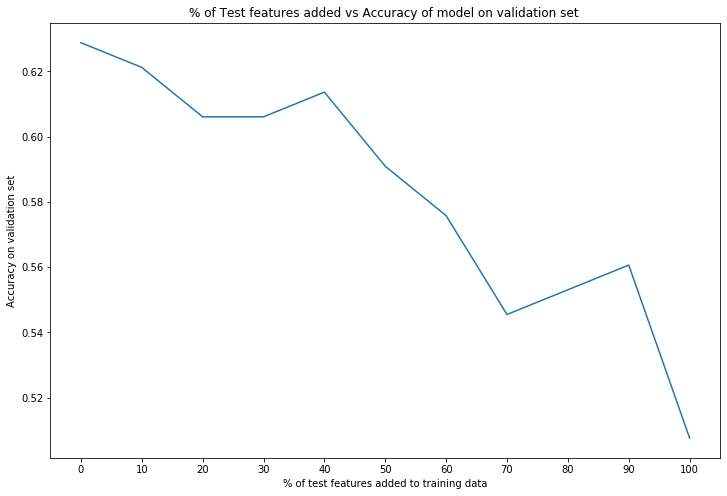

In [32]:
plt.figure(figsize=(12,8))
list_percentage = list(range(0,110,10))
plt.plot(list_percentage,accuracy_list)
plt.xticks(list_percentage)
plt.ylabel("Accuracy on validation set")
plt.xlabel("% of test features added to training data")
plt.title("% of Test features added vs Accuracy of model on validation set ")
plt.show()

16. Using the model that is trained on the entirety of the training data and 100% of the test data (labeled by you), generate a ﬁnal set of labels for the test data. Be sure to only use last names
in all caps for the labels, as you did in Question 12. Include these in your submission per the instructions below.


In [33]:
#Generating final set of labels on the test data

updatedModel = MultinomialNB(alpha=0.085).fit(new_train_X,new_train_y)
finalPredictions = updatedModel.predict(test_bigram_tfidf)


#Converting the results to upper case
finalPredictions=[x.upper() for x in finalPredictions]

#Appending the results to the final dataframe
result_Df['MODEL2'] = finalPredictions



#Removing punchuations from the model results

result_Df['MODEL2'] =result_Df['MODEL2'].apply(lambda x : x.replace(r"'",''))

#Rearranging the dataframe
result_Df=result_Df[['FILENAME','MODEL1','MODEL2']]

#Displaying the final results of the dataframe
result_Df 

#Writing the results to a text file
np.savetxt('results.txt', result_Df.values, delimiter="\t\t", fmt="%-12s", comments='', header="FILENAME\t\tMODEL1\t\t\tMODEL2")  